<a href="https://colab.research.google.com/github/coderAllDay/NeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import **Model** 

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.14.0

import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.python.keras.applications.vgg19 import VGG19

model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

Uninstalling tensorflow-1.14.0:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.14.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.14.0
  Using cached https://files.pythonhosted.org/packages/de/f0/96fb2e0412ae9692dbf400e5b04432885f677ad6241c088ccc5fe7724d69/tensorflow-1.14.0-cp36-cp36m-manylinux1_x86_64.whl


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# **Image Precessing And Display**

In [ ]:
def load_and_process_image(image_path):
  img = load_img(image_path)
  img = img_to_array(img)
  img = preprocess_input(img)
  img= np.expand_dims(img, axis = 0)
  return img

In [ ]:
def deprocess(x):
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68

  x = x[:,:,::-1]

  x = np.clip(x,0,255).astype('uint8')
  return x

In [ ]:
def display_image(image):
  if len(image.shape) == 4:
    img = np.squeeze(image, axis = 0)
  img = deprocess(img)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  return

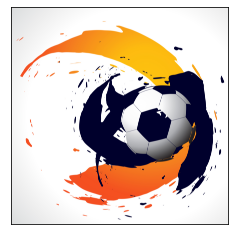

In [ ]:
display_image(load_and_process_image('Football10.jpg'))

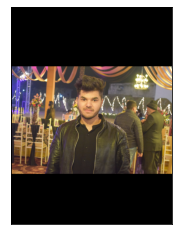

In [ ]:
display_image(load_and_process_image('Example2.png'))

## **Content And Style Models**

In [ ]:
content_layer = 'block5_conv2'
style_layers = [
                'block1_conv1',
                'block3_conv1',
                'block5_conv1'
]

In [ ]:
content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output)

In [ ]:
style_models = [Model(inputs = model.input, outputs = model.get_layer(layer).output) for layer in style_layers]

### **Content Cost**

In [ ]:
def content_cost(content,generated):
  a_C = content_model(content)
  a_G = content_model(generated)

  cost = tf.reduce_mean(tf.square(a_C - a_G))
  return cost

# **Gram Matrix**

In [ ]:
def gram_matrix(A):
  n_C = int(A.shape[-1])
  a = tf.reshape(A, [-1,n_C])
  n = tf.shape(a)[0]

  G = tf.matmul(a, a, transpose_a = True)
  return G/tf.cast(n, tf.float32)

## **Style Cost**

In [ ]:
lam = 1./len(style_models)
def style_cost(style, generated):
  J_style = 0
  for style_model in style_models:
    a_S = style_model(style)
    a_G = style_model(generated)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    current_cost = tf.reduce_mean(tf.square(GS - GG))
    J_style += current_cost*lam

  return J_style

# **Training Loop**

In [ ]:
import time
generated_images = []

def training_loop(content_path, style_path, iterations = 20, alpha = 10., beta = 20.):
  content = load_and_process_image(content_path)
  style = load_and_process_image(style_path)
  generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
  opt = tf.train.AdamOptimizer(learning_rate = 7.)

  best_cost = 1e12 + 0.1
  best_image = None
  start_time = time.time()

  for i in range(iterations):
    with tf.GradientTape() as tape:
      J_content = content_cost(content, generated)
      J_style = style_cost(style, generated)
      J_total = alpha*J_content + beta*J_style

    grads = tape.gradient(J_total, generated)
    opt.apply_gradients([(grads, generated)])

    
    best_cost = tf.minimum(best_cost,J_total)
    best_image = generated.numpy()
    print('Cost at{} : {}.Time elapsed : {}'.format(i,J_total, time.time() - start_time))
    generated_images.append(generated.numpy())
  return best_image 

In [ ]:
best_image = training_loop('Example2.png', 'Football10.jpg')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# **Plot Results **

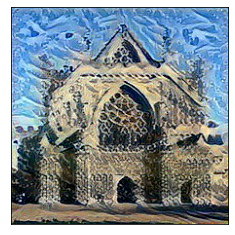

In [ ]:
display_image(best_image)

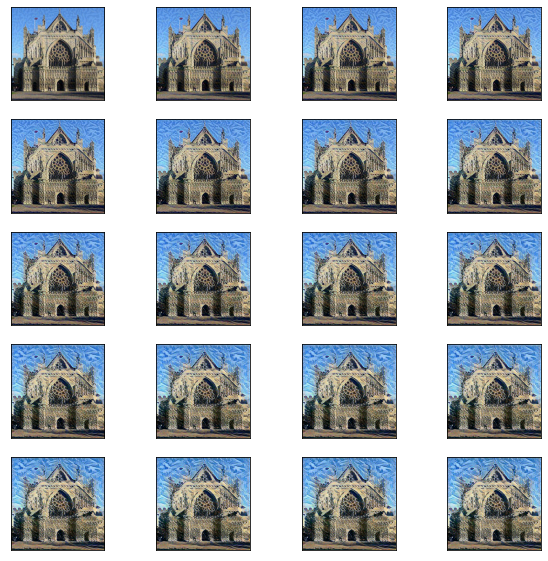

In [ ]:
plt.figure(figsize = (10,10))
for i in range(20):
  plt.subplot(5,4,i+1)
  display_image(generated_images[i])
plt.show()

# **COMPLETED**